<a href="https://colab.research.google.com/github/microprediction/pointy/blob/main/energy_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install microprediction
from collections import OrderedDict

In [ ]:
def a_model( ys, theta, ax=None, num_plot=50):
    """ Example of a time series model that supplies "anchor" points
        - this could be ARIMA or LSTM or whatever
    :param ys:    time series of observations
    :param theta: parameter vector
    :return: xs:  time series of (posterior) estimates
    """
    a = ys[0]
    xs = list()
    for y in ys:
        dy = y - a
        move = 2.0*(theta[1] * math.tanh( theta[0] * dy / theta[1] ))
        a = a + move
        xs.append(a)
    if ax is not None:
        ax.plot(range(num_plot),xs[-num_plot-1:-1],range(num_plot),ys[-num_plot:])
        ax.legend(['prior','data'])
    return xs

###Example of the model in action
One model chases the data more than the other

In [ ]:
STREAMS = ['emojitracker-twitter-face_with_medical_mask.json','electricity-lbmp-nyiso-millwd.json']
NAME = STREAMS[1]
from microprediction import MicroReader
mr = MicroReader()
YS = np.array(list(reversed(mr.get_lagged_values(name=NAME) ) )) # Example real time series

YS = np.cumsum(np.random.randn(1000))+np.random.choice([-1,1],size=1000)

In [ ]:
from scipy.stats import energy_distance, wasserstein_distance
import math 
def edist(zs:np.ndarray , num_batch:int=50, distance_metric=None)->float:
    """ Mean energy differential between residuals from one batch to the next """
    distance_metric = energy_distance if distance_metric is None else distance_metric
    zchunks = [zs[i:i + num_batch] for i in range(0, len(zs), num_batch)]
    return np.mean( [ energy_distance(u_values=zchunks[i], v_values=zchunks[i+1]) for i in range(len(zchunks)-1) ] )

def objective(theta):
    xs = a_model( ys=YS, theta=[theta[0],math.exp(theta[1])], ax=None)
    zs = np.array(YS[:-1])-np.array(xs[1:])
    return edist(zs)

# Optimize for best theta
bounds = [(0.01,0.99),(-3,5)]
from scipy.optimize import shgo
result = shgo(objective, bounds, n=100, options={'maxiter':5,'ftol':1e-6})
result.x

array([0.25737526, 4.99999996])

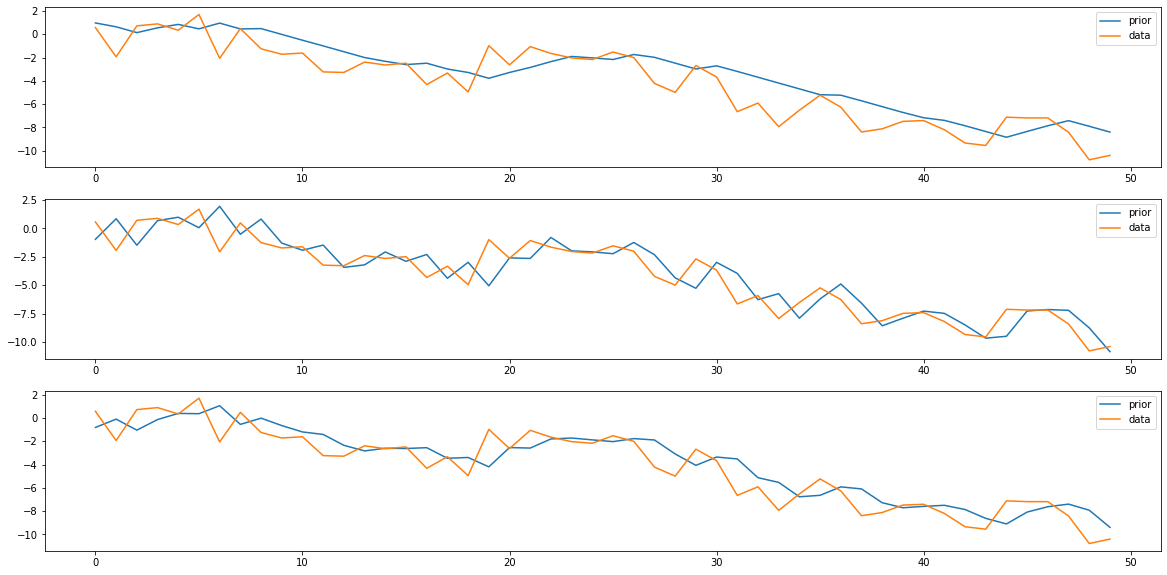

In [ ]:
theta_optimal = [ result.x[0], math.exp(result.x[1]) ]
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig,axs = plt.subplots(3,1)
a_model( ys=YS, theta=[0.5,0.25], ax=axs[0])
a_model( ys=YS, theta=[0.75,1.25], ax=axs[1])
a_model( ys=YS, theta=theta_optimal, ax=axs[2])
fig.show()

In [ ]:
result.x

array([0.28328898, 0.92203052])

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fef53382550>)

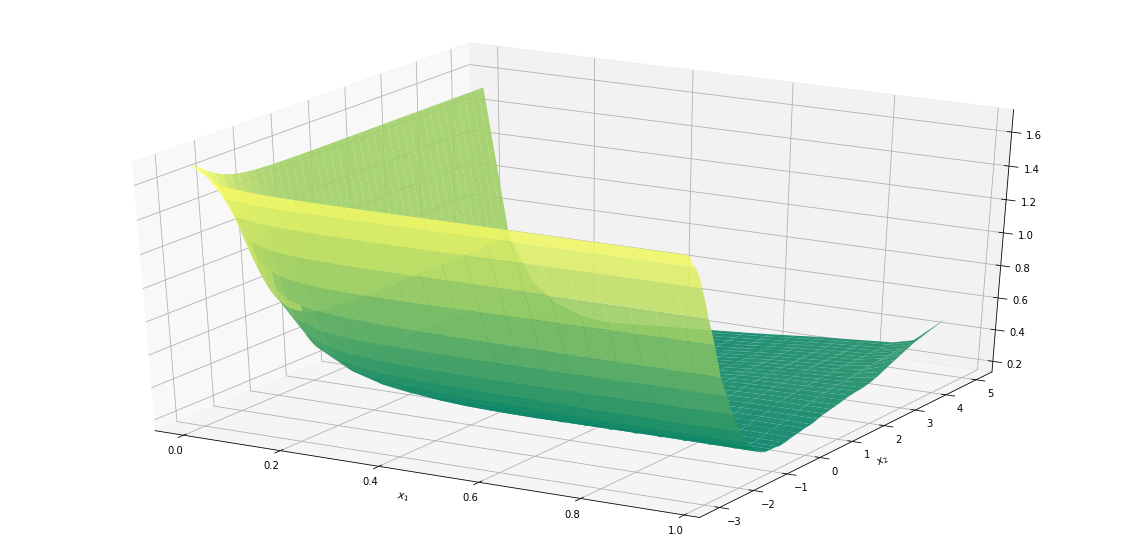

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
RESOLUTION = 0.05    # Used 0.003 for plots
from matplotlib import cm
GOLF_COLOR_MAP = cm.summer
def mesh2d_xy(f,bounds,resolution=RESOLUTION,cmap=GOLF_COLOR_MAP):
    """ Plot function taking two arguments
        f(x,y)
    """
    x1 = np.arange( bounds[0][0], bounds[0][1],resolution )
    x2 = np.arange( bounds[1][0], bounds[1][1], resolution)

    X1, X2 = np.meshgrid(x1, x2)
    zs = np.array([ f([x1_,x2_]) for x1_,x2_ in zip( np.ravel(X1), np.ravel(X2)) ])
    Z = zs.reshape(X1.shape)

    ax.plot_surface(X1, X2, Z, alpha=0.9,cmap=cmap)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    return fig, ax
mesh2d_xy(objective,bounds)